## Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DCGAN'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['config.json', 'utils.py', 'model.py', '__pycache__', 'dataset.py', 'DCGAN.ipynb']


In [3]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import json
from model import Generator, Discriminator
from dataset import data

device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
with open(os.path.join(GOOGLE_DRIVE_PATH, 'config.json')) as f:
        config = json.load(f)

## Dataset

In [4]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2021-01-16 13:59:16--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.56
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  74.4MB/s    in 17s     

2021-01-16 13:59:33 (82.2 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [4]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

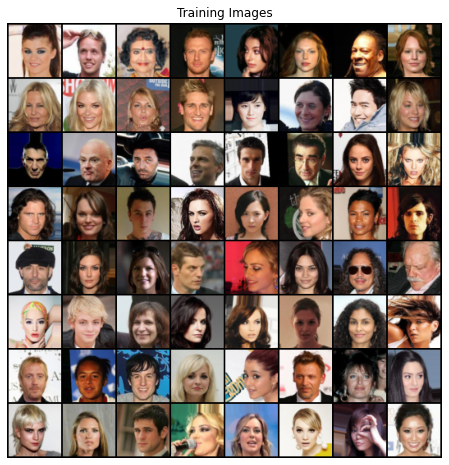

In [5]:
import matplotlib.pyplot as plt
import numpy as np

dataloader = data('data_faces/')

real_batch = next(iter(dataloader))
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_title("Training Images")
ax.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.show()

In [6]:
from utils import weights_init

netG = Generator(config['Generator']).to(device)
netD = Discriminator(config['Discriminator']).to(device)


In [7]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(128, 100, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=config['lr'], betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=config['lr'], betas=(0.5, 0.999))

In [12]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
num_epochs = 10
for epoch in range(3):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)

        # batch_size에서 label 생성
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # D : log(D(x))
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # D: log(1-D(G(z)))
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake.detach()).view(-1)
        label.fill_(fake_label)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # G : log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4}\tLoss_G: {errG.item():.4}\tD(x): {D_x:.4}\tD(G(z)): {D_G_z1:.4} / {D_G_z2:.4}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/10][0/1583]	Loss_D: 0.1528	Loss_G: 4.9923	D(x): 0.9612	D(G(z)): 0.0910 / 0.0099
[0/10][100/1583]	Loss_D: 0.1430	Loss_G: 10.7384	D(x): 0.9753	D(G(z)): 0.1076 / 0.0000
[0/10][200/1583]	Loss_D: 0.4748	Loss_G: 2.9793	D(x): 0.7020	D(G(z)): 0.0592 / 0.0859
[0/10][300/1583]	Loss_D: 0.3822	Loss_G: 4.2119	D(x): 0.8927	D(G(z)): 0.2135 / 0.0208
[0/10][400/1583]	Loss_D: 0.4983	Loss_G: 3.5548	D(x): 0.8711	D(G(z)): 0.2749 / 0.0420
[0/10][500/1583]	Loss_D: 0.3255	Loss_G: 3.7737	D(x): 0.8824	D(G(z)): 0.1635 / 0.0320
[0/10][600/1583]	Loss_D: 0.4301	Loss_G: 3.8328	D(x): 0.7090	D(G(z)): 0.0406 / 0.0311
[0/10][700/1583]	Loss_D: 0.5498	Loss_G: 4.7367	D(x): 0.8727	D(G(z)): 0.3138 / 0.0107
[0/10][800/1583]	Loss_D: 0.5584	Loss_G: 2.8685	D(x): 0.7537	D(G(z)): 0.1965 / 0.0744
[0/10][900/1583]	Loss_D: 1.0210	Loss_G: 2.1255	D(x): 0.4880	D(G(z)): 0.0624 / 0.1635
[0/10][1000/1583]	Loss_D: 0.5612	Loss_G: 3.4747	D(x): 0.8263	D(G(z)): 0.2822 / 0.0391
[0/10][1100/1583]	Loss_D: 1.0786	Loss_G

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


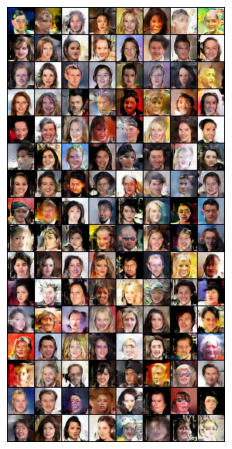

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())